In [69]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function Definitions

### Supporting Functions

####  Returns a boolean list (mask) indicating when match is contained in the target_column of data.


In [70]:
def make_mask(data, match, target_column):
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(match, str):
        raise TypeError("'plan' should be of type 'str': received {} instead".format(type(match)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    
    # Check for correct arguments' value
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))

    if match == "All":
        size = len(data[target_column])
        mask = [True]*size # list full of True with the same lenght as the data
    
    else:
        mask = list(data[target_column] == match)
    
    
    return mask



### Given a pandas DataFrame, split the user journey strings into separate pages.
###    It does not update the DataFrame, rather returns a new numpy array.
    
###    A user journey string is a string of the pages a user visited before purchassing, separated by a dash '-'.
###    This function removes the dash and obtains a numpy array of all the pages (as strings).
    

In [71]:
def split_pages(data, target_column = "user_journey"):
   
    
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    
    # Check for correct arguments' value
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))
    
    
    
    ### MAIN FUNCTION BODY ###
    
    
    # Transform the user journey column to a numpy array
    # numpy.array needed in order to be able to use a mask (filter)
    user_journeys = np.array(data[target_column])
    
    
    # Split the journey strings into pages -> [["page1", "page2", ..."pageN"], ...]
    for i in range(len(user_journeys)):
        user_journeys[i] = np.array(user_journeys[i].split("-"))
    
    
    return user_journeys


###     Obtain the set (unique values) of all pages contained in the data.


In [72]:
def get_pages_set(data, target_column = "user_journey"):
    """
        Returns:
            pages_set (set): A set of all unique pages contained in the user journey strings
    """
    
    
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    
    # Check for correct arguments' value
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))
    
    
    
    ### MAIN FUNCTION BODY ###
    
    
    # Obtain a list of the pages in each journey string -> [["page1", "page2", ..."pageN"], ...]
    user_journeys = [journey.split("-") for journey in list(data[target_column])]
    
    # Create an empty set and update it for each user journey
    pages_set = set()
    for journey in user_journeys:
        pages_set.update(journey)
    
    
    return pages_set


## Main Functions

###  page_count : It Calculates the number of times each page is found in the user journey strings.


In [73]:
def page_count(data, target_column = 'user_journey', plan = "All", mask = None, sort = True):
    """
   
        Returns:
            dict {str: int}: A dictionary of every page and its count 
                {page: count}
    """
    
    
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(plan, str):
        raise TypeError("'plan' should be of type 'str': received {} instead".format(type(plan)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    if mask is not None:
        if not isinstance(mask, list):
            raise TypeError("'mask' should be of type 'list': received {} instead".format(type(mask)))
        for item in mask:
            if not isinstance(item, bool):
                raise TypeError("'mask' should be a list of 'bool': received list of {} instead".format(type(item)))
    
    if not isinstance(sort, bool):
        raise TypeError("'sort' should be of type 'bool': received {} instead".format(type(sort)))
    
    
    # Check for correct arguments' value
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))
    
    if mask is not None and len(mask) != len(data):
        raise ValueError("'mask' should have the same length as 'data'")
    
    
    # Warn for potential mistake in 'plan'
    if plan not in ("All", "Monthly", "Quarterly", "Annual"):
        warnings.warn("\n\nThe supplied string to plan is not recognized as a standard subscription plan. "
                      "Please, check your spelling. "
                      "If you intended to filter by plan = '{}', you can ignore this warning.\n"
                      "\nStandard subscription plans are: 'All', 'Monthly', 'Quarterly', 'Annual'.\n".format(plan),
                     stacklevel = 2)
    
    
    
    ### MAIN FUNCTION BODY ###
    
    
    
    # Set the proper mask if none was provided by the user
    if mask is None:
        mask = make_mask(data, plan, "subscription_type")
    
    # Obtain the relevant array of user journey pages
    user_journeys = split_pages(data, target_column)
    user_journeys = user_journeys[mask]
    
    
    # Define the empty result dictionary
    results = {}
    results["Total pages"] = 0
    
    # Populate the dictionary with page counts
    for journey in user_journeys:
        for page in journey:
            results[page] = results.get(page, 0) + 1
            results["Total pages"] = results["Total pages"] + 1
    
    
    if not sort:
        return results
    
    # Create a new dictionary, sorted by values (page counts) in decreasing order
    sorted_keys = sorted(results, key = results.get, reverse = True)
    sorted_results = {key: results[key] for key in sorted_keys}
    
    
    
    return sorted_results
    

### page_presence : It Finds the number of journeys each page is present in (from the user jounrey strings).


In [74]:
def page_presence(data , target_column='user_journey' , plan='All' , mask=None , sort=True):
    """
        Returns:
            dict {str: int}: A dictionary of every page and the number of journeys it is present in 
                {page: count_journeys}
        
    """
    
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(plan, str):
        raise TypeError("'plan' should be of type 'str': received {} instead".format(type(plan)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    if mask is not None:
        if not isinstance(mask, list):
            raise TypeError("'mask' should be of type 'list': received {} instead".format(type(mask)))
        for item in mask:
            if not isinstance(item, bool):
                raise TypeError("'mask' should be a list of 'bool': received list of {} instead".format(type(item)))
    
    if not isinstance(sort, bool):
        raise TypeError("'sort' should be of type 'bool': received {} instead".format(type(sort)))
    
    
    # Check for correct arguments' value
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))
    
    if mask is not None and len(mask) != len(data):
        raise ValueError("'mask' should have the same length as 'data'")
    
    
    # Warn for potential mistake in 'plan'
    if plan not in ("All", "Monthly", "Quarterly", "Annual"):
        warnings.warn("\n\nThe supplied string to plan is not recognized as a standard subscription plan. "
                      "Please, check your spelling. "
                      "If you intended to filter by plan = '{}', you can ignore this warning.\n"
                      "\nStandard subscription plans are: 'All', 'Monthly', 'Quarterly', 'Annual'.\n".format(plan),
                     stacklevel = 2)
    

    ### MAIN FUNCTION BODY ###
    
    # Set the proper mask if none was provided by the user
    if mask is None:
        mask = make_mask(data, plan, "subscription_type")

    # Obtain the relevant array of user journey pages
    user_journeys = split_pages(data, target_column)
    user_journeys = user_journeys[mask]

    
    # Define the empty result dictionary
    results = {}
    results["Total journeys"] = len(user_journeys)

    # Populate the dictionary with count journeys for each page
    for journey in user_journeys:
        ##pages = set(journey) converts the list of pages in a journey into a set, which automatically removes any duplicate pages 
        pages = set(journey) # Unique pages in a journey
        
        for page in pages:
            results[page] = results.get(page, 0) + 1
    
    
    if not sort:
        return results
    
    # Create a new dictionary, sorted by values (page counts) in decreasing order
    sorted_keys = sorted(results, key = results.get, reverse = True)
    sorted_results = {key: results[key] for key in sorted_keys}
    
    
    
    return sorted_results


### page_destinations :  For each page finds all follow up pages and their count (from the user journey strings).


In [75]:
def page_destinations (data , target_column='user_journey' , plan="All" , mask=None  , sort=True):
    """
        Returns:
            dict {str: {str: int}}: A dictionary of every (starting) page.
                The value is another dictionary containing all follow up pages and their count 
                {starting_page: {next_page: count}}
    """
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(plan, str):
        raise TypeError("'plan' should be of type 'str': received {} instead".format(type(plan)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    if mask is not None:
        if not isinstance(mask, list):
            raise TypeError("'mask' should be of type 'list': received {} instead".format(type(mask)))
        for item in mask:
            if not isinstance(item, bool):
                raise TypeError("'mask' should be a list of 'bool': received list of {} instead".format(type(item)))
    
    if not isinstance(sort, bool):
        raise TypeError("'sort' should be of type 'bool': received {} instead".format(type(sort)))
    
    
    # Check for correct arguments' value
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))
    
    if mask is not None and len(mask) != len(data):
        raise ValueError("'mask' should have the same length as 'data'")
    
    
    # Warn for potential mistake in 'plan'
    if plan not in ("All", "Monthly", "Quarterly", "Annual"):
        warnings.warn("\n\nThe supplied string to plan is not recognized as a standard subscription plan. "
                      "Please, check your spelling. "
                      "If you intended to filter by plan = '{}', you can ignore this warning.\n"
                      "\nStandard subscription plans are: 'All', 'Monthly', 'Quarterly', 'Annual'.\n".format(plan),
                     stacklevel = 2)
    
    ### MAIN FUNCTION BODY ###
        
    # Set the proper mask if none was provided by the user
    if mask is None:
        mask = make_mask(data, plan, "subscription_type")
    
    # Obtain the relevant array of user journey pages
    user_journeys = split_pages(data, target_column)
    user_journeys = user_journeys[mask]

    # Construct a dictionary with keys being all the pages contained in user journeys
    results = { key: dict() for key in get_pages_set(data, target_column)}
    # Populate the dictionary
    for journey in user_journeys:
        for i in range(len(journey) - 1):
            page_source = journey[i]
            page_next = journey[i+1]
        
            results[page_source][page_next] = results[page_source].get(page_next, 0) + 1
    
    if not sort:
        return results
    
    
    
    sorted_results = {}
    
    # Sort the sub-dictionaries by values (page_destionation counts) in decreasing order
    for page in results:
        unsorted_dict = results[page]
        sorted_keys = sorted(unsorted_dict, key = unsorted_dict.get, reverse = True)
    
        sorted_results[page] = { key: unsorted_dict[key] for key in sorted_keys}
    
    
    
    return sorted_results



### page_sequences : It Finds the top consecutive page strings and their count (from the user jounrey strings).

In [76]:
def page_sequences(data, number_of_pages = 3, show_results = 10, target_column = 'user_journey', 
                      plan = "All", mask = None, sort = True):
    """
        Returns:
            dict {tuple(str): int}: A dictionary where the key is a page combination tuple and the value is its count.
                The result is sorted and contains only the top (show_results) tuples.
                If sort = False, return all page combinations, unsorted.
                {(page1, page2, ... pageN): count}
    """
    
    
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(number_of_pages, int):
        raise TypeError("'number_of_pages' should be of type 'int': received {} instead".format(type(number_of_pages)))
    
    if not isinstance(show_results, int):
        raise TypeError("'show_results' should be of type 'int': received {} instead".format(type(show_results)))
    
    if not isinstance(plan, str):
        raise TypeError("'plan' should be of type 'str': received {} instead".format(type(plan)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    if mask is not None:
        if not isinstance(mask, list):
            raise TypeError("'mask' should be a list of 'bool': received {} instead".format(type(mask)))
        for item in mask:
            if not isinstance(item, bool):
                raise TypeError("'mask' should be a list of 'bool': received list of {} instead".format(type(item)))
    
    if not isinstance(sort, bool):
        raise TypeError("'sort' should be of type 'bool': received {} instead".format(type(sort)))
    
    
    # Check for correct arguments' value
    if number_of_pages < 0:
        raise ValueError("'number_of_pages' must be a non-negative integer")
    
    if show_results < 0:
        raise ValueError("'show_results' must be a non-negative integer")
    
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))
    
    if mask is not None and len(mask) != len(data):
        raise ValueError("'mask' should have the same length as 'data'")
    
    
    # Warn for potential mistake in 'plan'
    if plan not in ("All", "Monthly", "Quarterly", "Annual"):
        warnings.warn("\n\nThe supplied string to plan is not recognized as a standard subscription plan. "
                      "Please, check your spelling. "
                      "If you intended to filter by plan = '{}', you can ignore this warning.\n"
                      "\nStandard subscription plans are: 'All', 'Monthly', 'Quarterly', 'Annual'.\n".format(plan),
                     stacklevel = 2)
    
    
    ### MAIN FUNCTION BODY ###
    
    
    
    # Set the proper mask if none was provided by the user
    if mask is None:
        mask = make_mask(data, plan, "subscription_type")
    
    # Obtain the relevant array of user journey pages
    user_journeys = split_pages(data, target_column)
    user_journeys = user_journeys[mask]
    
    
    # Define the empty result dictionary
    results = {}
    
    # Populate the result dictionary
    for journey in user_journeys:
        
        flag = {} # Used to stop double counting of the same page combination in the same journey
        
        for i in range(len(journey) - number_of_pages + 1):
            
            page_combination = tuple(journey[i : i + number_of_pages])

            if flag.get(page_combination, False): continue # If we have counted it already, skip it
            
            results[page_combination] = results.get(page_combination, 0) + 1
            flag[page_combination] = True # Flag this combination as already counted in this journey
    
    
    
    if not sort:
        return results
    
    # Create a new dictionary, sorted by values (page counts) in decreasing order
    # Take only top 'show_results' pages
    sorted_keys = sorted(results, key = results.get, reverse = True)[:show_results]
    sorted_results = {key: results[key] for key in sorted_keys}

    
    return sorted_results


### avg_journey_length: Finds the average length of a user journey in terms of the number of pages.

In [77]:
def avg_journey_length(data, target_column = 'user_journey', plan = "All", mask = None):
    """
        Returns:
            float: The average number of pages in the relevant user journey strings.
    """
    
    
    # Check for correct arguments' type
    if not isinstance(data, pd.DataFrame):
        raise TypeError("'data' should be of type 'pandas.DataFrame': received {} instead".format(type(data)))
    
    if not isinstance(plan, str):
        raise TypeError("'plan' should be of type 'str': received {} instead".format(type(plan)))
    
    if not isinstance(target_column, str):
        raise TypeError("'target_column' should be of type 'str': received {} instead".format(type(target_column)))
    
    if mask is not None:
        if not isinstance(mask, list):
            raise TypeError("'mask' should be a list of 'bool': received {} instead".format(type(mask)))
        for item in mask:
            if not isinstance(item, bool):
                raise TypeError("'mask' should be a list of 'bool': received list of {} instead".format(type(item)))
    
    
    # Check for correct arguments' value
    if target_column not in data.columns:
        raise ValueError("No column named '{}' in the data".format(target_column))
    
    if mask is not None and len(mask) != len(data):
        raise ValueError("'mask' should have the same length as 'data'")
    
    
    # Warn for potential mistake in 'plan'
    if plan not in ("All", "Monthly", "Quarterly", "Annual"):
        warnings.warn("\n\nThe supplied string to plan is not recognized as a standard subscription plan. "
                      "Please, check your spelling. "
                      "If you intended to filter by plan = '{}', you can ignore this warning.\n"
                      "\nStandard subscription plans are: 'All', 'Monthly', 'Quarterly', 'Annual'.\n".format(plan),
                     stacklevel = 2)
    
    
    
    # Set the proper mask if none was provided by the user
    if mask is None:
        mask = make_mask(data, plan, "subscription_type")
    
    # Obtain the relevant array of user journey pages
    user_journeys = split_pages(data, target_column)
    user_journeys = user_journeys[mask]
    
    
    # Find the total amount of pages in all user journeys
    total = 0
    for i in range(len(user_journeys)):
        total = total + len(user_journeys[i])
        
    # The average journey length is the total amount of pages divided by the numebr of user journeys
    avg_len = total/len(user_journeys)
    
    
    return avg_len


## Main

In [78]:
data = pd.read_csv('cleaned_user_journey/user_journey.csv')
data

,user_id,subscription_type,user_journey
0,1516,Annual,Homepage-Log in-Other-Sign up-Log in-Homepage-...
1,3395,Annual,Other-Pricing-Sign up-Log in-Homepage-Pricing-...
2,10107,Annual,Homepage-Career tracks-Homepage-Career tracks-...
3,11145,Monthly,Homepage-Log in-Homepage-Log in-Homepage-Log i...
4,12400,Monthly,Homepage-Career tracks-Sign up-Log in-Other-Ca...
...,...,...,...
1345,509060,Annual,Other
1346,509061,Annual,Coupon
1347,509085,Annual,Coupon
1348,509095,Annual,Other


### Most popular pages

In [79]:
page_counts= page_count(data, plan = "All", sort = True)
page_counts

{'Total pages': 14098,
 'Homepage': 2679,
 'Log in': 2234,
 'Checkout': 1351,
 'Sign up': 1247,
 'Other': 1189,
 'Courses': 1087,
 'Career tracks': 1070,
 'Pricing': 1053,
 'Coupon': 720,
 'Resources center': 546,
 'Career track certificate': 468,
 'Course certificate': 212,
 'Upcoming courses': 110,
 'Success stories': 49,
 'Instructors': 43,
 'About us': 20,
 'Blog': 20}

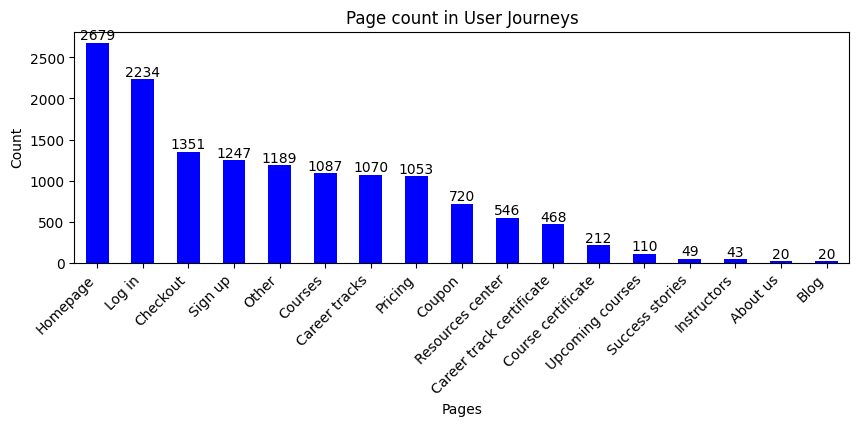

In [80]:
if "Total pages" in page_counts:
    del page_counts["Total pages"]

page_counts_series = pd.Series(page_counts)

plt.figure(figsize=(10, 3))
page_counts_series.plot(kind='bar', color='blue')
plt.title('Page count in User Journeys')
plt.xlabel('Pages')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

for i, count in enumerate(page_counts_series):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()


### How many times each page is part of a journey

In [81]:
page_presences = page_presence(data, plan = "All", sort = True)
page_presences

{'Total journeys': 1350,
 'Homepage': 843,
 'Checkout': 821,
 'Log in': 756,
 'Sign up': 738,
 'Other': 623,
 'Coupon': 606,
 'Pricing': 476,
 'Courses': 453,
 'Career tracks': 380,
 'Career track certificate': 228,
 'Resources center': 184,
 'Course certificate': 151,
 'Upcoming courses': 83,
 'Success stories': 38,
 'Instructors': 25,
 'About us': 17,
 'Blog': 13}

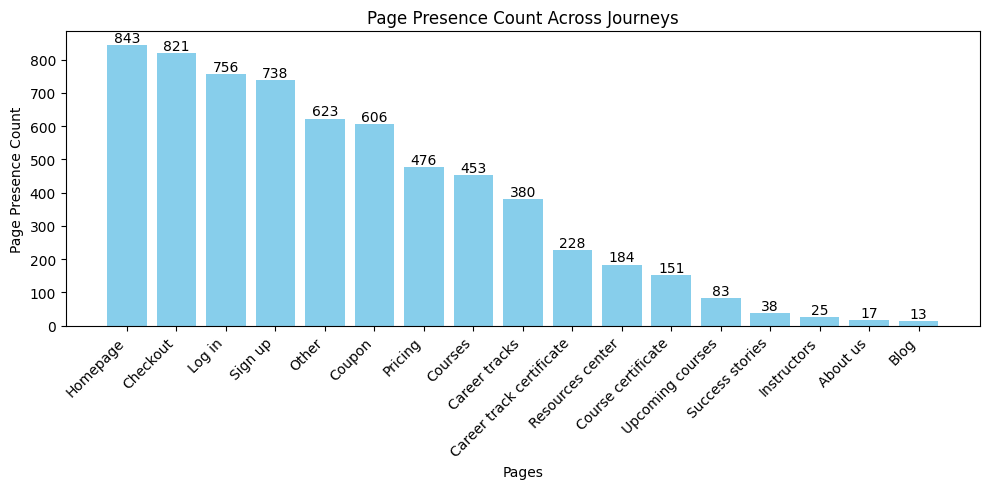

In [82]:
if "Total journeys" in page_presences:
    del page_presences["Total journeys"]

# Extract keys and values for plotting
pages = list(page_presences.keys())
counts = list(page_presences.values())

# Plotting
fig = plt.figure(figsize=(10, 5))
plt.bar(pages, counts, color='skyblue')
plt.xlabel('Pages')
plt.ylabel('Page Presence Count')
plt.title('Page Presence Count Across Journeys')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add text labels for each bar
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.show()


### Most frequent follow-up after every page

In [83]:
page_destinations(data, plan = "All", sort = True)['Homepage']

{'Log in': 953,
 'Pricing': 449,
 'Career tracks': 357,
 'Sign up': 341,
 'Courses': 246,
 'Career track certificate': 117,
 'Course certificate': 66,
 'Resources center': 51,
 'Other': 33,
 'Instructors': 25,
 'Coupon': 12,
 'Upcoming courses': 10,
 'About us': 5,
 'Checkout': 5,
 'Success stories': 4,
 'Blog': 4}

### Most popular N page strings

In [84]:
page_sequences(data, number_of_pages = 3, show_results = 10, plan = "All", sort = True)

{('Homepage', 'Log in', 'Checkout'): 239,
 ('Log in', 'Homepage', 'Log in'): 220,
 ('Homepage', 'Log in', 'Homepage'): 180,
 ('Sign up', 'Log in', 'Checkout'): 123,
 ('Sign up', 'Log in', 'Homepage'): 104,
 ('Homepage', 'Pricing', 'Checkout'): 100,
 ('Homepage', 'Sign up', 'Log in'): 97,
 ('Sign up', 'Homepage', 'Log in'): 94,
 ('Homepage', 'Sign up', 'Homepage'): 90,
 ('Log in', 'Other', 'Log in'): 83}

### Average length of a journey (pages)

In [85]:
avg_journey_length(data, plan = "All")

10.442962962962962